In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import data_reading, music_generation
from models import music_generation_VAE
from dataset import iterable_dataset
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
SEQ_LEN = 48
RESOLUTION = 12
TRAIN_SPLIT = 0.8
HIDDEN_SIZE = 512
BATCH_SIZE = 64
N_LAYERS = 6
CUT_TIME_RATIO = 0.1
TEST_FILE_NUMBER = 10
CUTOFF_P = 1.5
BUFFER_SIZE = 10
FILES_TO_READ = 10
PROJECT_DIR ="D:/522 project"
PPR_DIR = "lpd_5_pianoroll"
SAVE_DIR = "./vae_piano"
TRACK_ORDER = ["Piano"]
#with open(SCALER_DICT_SAVE_PATH, "rb") as file:
#    scaler_dict = pickle.load(file)
scaler_dict = None
PATH = os.path.join(PROJECT_DIR, PPR_DIR)
MODEL_STATE_PATH = "./vae_piano/P_vae_trained_r12s48d25e20"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = music_generation_VAE.ConvVAE(TRACK_ORDER, HIDDEN_SIZE)
model.load_state_dict(torch.load(MODEL_STATE_PATH))
model.to(DEVICE)


ConvVAE(
  (enc_conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
  (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (enc_conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (trans_enc_lin1): Linear(in_features=7168, out_features=512, bias=True)
  (trans_enc_lin2): Linear(in_features=512, out_features=256, bias=True)
  (trans_enc_lin3): Linear(in_features=256, out_features=513, bias=True)
  (trans_dec1): Linear(in_features=512, out_features=256, bias=True)
  (trans_dec2): Linear(in_features=256, out_features=512, bias=True)
  (trans_dec3): Linear(in_features=512, out_features=7168, bias=True)
  (dec_conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (dec_conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (dec_conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (dec_conv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))

In [3]:
all_files_list = data_reading.read_all_npzs(PATH, shuffle=True)
all_files_list = all_files_list[:TEST_FILE_NUMBER]
piano_dataset = iterable_dataset.IterableSongDataset(all_files_list, SEQ_LEN, RESOLUTION, TRACK_ORDER, 
                                          method="shift_window", normalize=False, binarize=False,
                                          buffer_size=BUFFER_SIZE, files_to_read=FILES_TO_READ)

In [14]:
original_tracks_dict, generated_tracks_dict = music_generation.check_vae_generation(model, piano_dataset, DEVICE)

reloading
torch.Size([1, 36432, 128])
torch.Size([1, 36432, 128])


In [27]:
orignal_tracks = music_generation.binarize_generated_music_dict(original_tracks_dict, 5, False, vol=85)
generated_tracks = music_generation.binarize_generated_music_dict(generated_tracks_dict, 10, False, vol=85)

Piano mean:  tensor(1.1631, device='cuda:0')
Piano mean:  tensor(1.0871, device='cuda:0', grad_fn=<MeanBackward0>)


In [28]:
orignal_tracks = music_generation.create_multitrack(orignal_tracks, RESOLUTION)
generated_tracks = music_generation.create_multitrack(generated_tracks, RESOLUTION)

[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

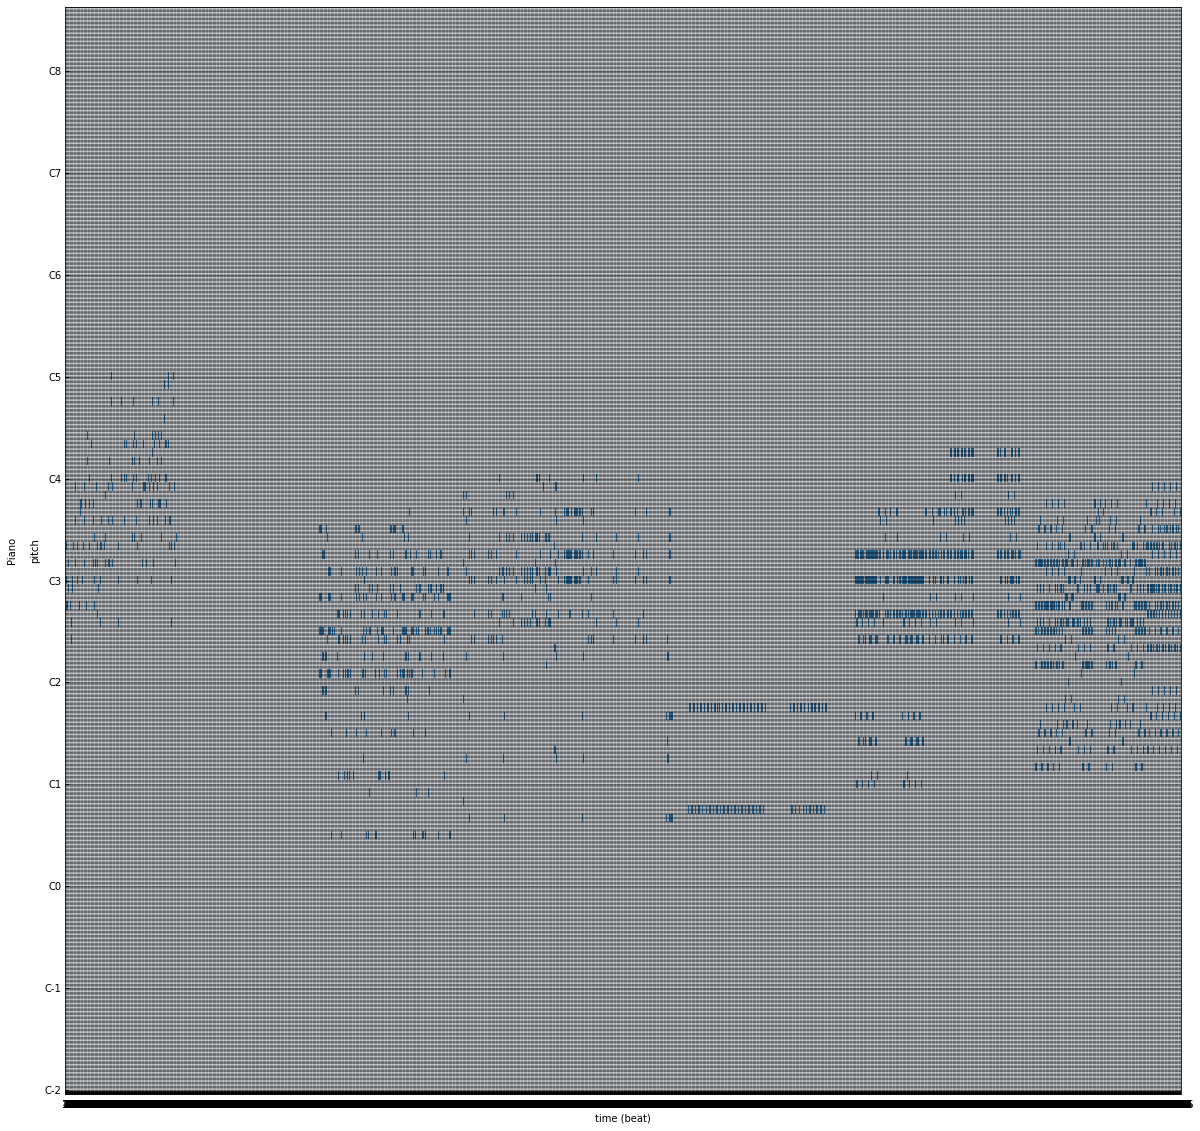

In [29]:
plt.rcParams["figure.figsize"] = (20,20)
orignal_tracks.plot()

[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

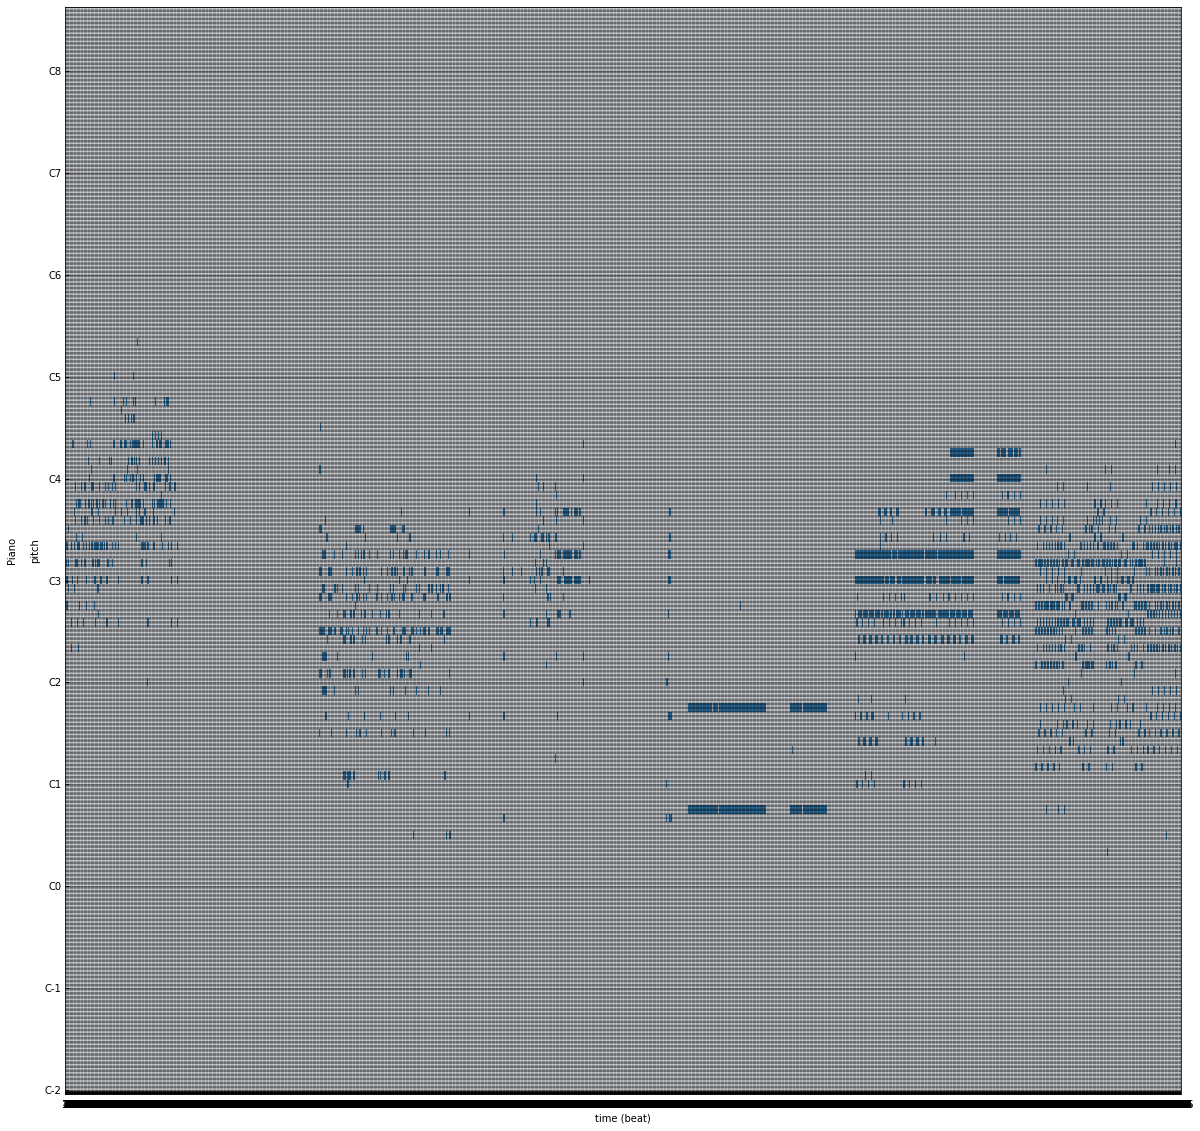

In [30]:
generated_tracks.plot()

In [31]:
orignal_tracks.binarize().write("vae_piano_original_music.mid")

In [32]:
generated_tracks.binarize().write("vae_piano_reconstructed_music.mid")